In [1]:
# @title Install Alibi
try:
  import alibi
except:
  !pip install alibi

     |████████████████████████████████| 235kB 5.5MB/s 
     |████████████████████████████████| 327kB 7.4MB/s 
     |████████████████████████████████| 28.0MB 144kB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463904 sha256=2a635b3917a1dd1e98754990b18397adac722d0795dbaeb5608c49fa5a2c09c0
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
  Created wheel for spacy-lookups-data: filename=spacy_lookups_data-0.1.0-py2.py3-none-any.whl size=28052145 sha256=a1866d0ef52e2b9b16d843eec97f02cc5adbc5e013e8fae2109986257e6bc2ff
  Stored in directory: /root/.cache/pip/wheels/2a/2b/0a/d6fb6235c56d014d224bca760d15d7cbdd820813085ffcd35d
Successfully built shap spacy-lookups-data


In [3]:
# @title Import Modules
import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR) # suppress
                                           # deprecation messages

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D,Dense, Dropout, Flatten, MaxPooling2D,Input,UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt 
import numpy as np 
import os
from time import time
from alibi.explainers import CEM

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28) y_train shape: (60000,)


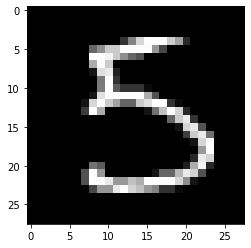

In [4]:
# @title Load and prepare MNIST data
(x_train, y_train),(x_test,y_test) =tf.keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:',
      y_train.shape)
plt.gray()
plt.imshow(x_test[15]);



In [5]:
# @title Preparing data: scaling the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print(x_test[1])

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.45490196 0.49019608
  0.6705882

In [6]:
# @title Preparing data: shaping the data
print("Initial Shape", x_test.shape)
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)

Initial Shape (10000, 28, 28)
x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)


In [7]:
# @title Preparing data: categorizing the data
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) /
    (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

 

y_train shape: (60000, 10) y_test shape: (10000, 10)


In [8]:
# @title Create and train CNN model
def cnn_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64, kernel_size=2, padding='same',
               activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = Conv2D(filters=32, kernel_size=2, padding='same',
               activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)
    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return cnn



In [9]:
train_cnn = 'yes' # @param ["yes","no"]
if train_cnn == "yes":
  cnn = cnn_model()
  cnn.summary()
  cnn.fit(x_train, y_train, batch_size=64, epochs=3, verbose=0)
  cnn.save('mnist_cnn.h5')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0     

In [10]:
# @title Load and test accuracy on test dataset
cnn = load_model('/content/mnist_cnn.h5')
cnn.summary()
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0     

In [11]:
# @title Define and train autoencoder
def ae_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu',
               padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    autoencoder = Model(x_in, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

In [12]:
train_auto_encoder = 'yes' # @param ["yes","no"]
if train_auto_encoder == "yes":
  ae = ae_model()
  # ae.summary()
  ae.fit(x_train, x_train, batch_size=128, epochs=4,
         validation_data=(x_test, x_test), verbose=0)
  ae.save('mnist_ae.h5', save_format='h5')

In [13]:
# @title Compare original with decoded images
ae = load_model('/content/mnist_ae.h5')
ae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 1)         145       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 28, 28, 16)        0   

In [14]:
decoded_imgs = ae.predict(x_test)


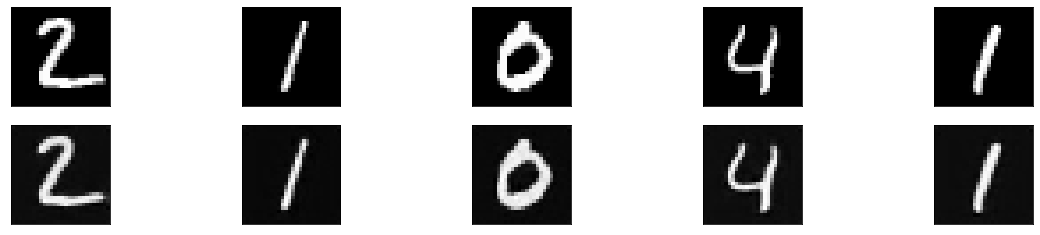

In [26]:
n = 5
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

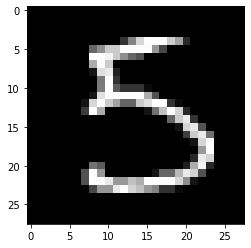

In [17]:
# @title Generate contrastive explanation with pertinent negative
# Explained instance
idx = 15
X = x_test[idx].reshape((1,) + x_test[idx].shape)
plt.imshow(X.reshape(28, 28));

In [18]:
# @title Model prediction
cnn.predict(X).argmax(), cnn.predict(X).max()

(5, 0.9998541)

In [21]:

# @title CEM parameters
# 'PN' (pertinent negative) or 'PP' (pertinent positive):
mode = 'PN'
# instance shape
shape =(1,) + x_train.shape[1:]
# minimum difference needed between the prediction probability
# for the perturbed instance on the class predicted by the
# original instance and the max probability on the other classes
# in order for the first loss term to be minimized:
kappa =0.
# weight of the L1 loss term:
beta = .1
# weight of the optional autoencoder loss term:
gamma =100
# initial weight c of the loss term encouraging to predict a
# different class (PN) or the same class (PP) for the perturbed
# instance compared to the original instance to be explained:
c_init =1.
# nb of updates for c:
c_steps =10
# nb of iterations per value of c:
max_iterations =1000
# feature range for the perturbed instance:
feature_range =(x_train.min(),x_train.max())
# gradient clipping:
clip =(-1000.,1000.)
# initial learning rate:
lr =1e-2
# a value, float or feature-wise, which can be seen as containing
# no info to make a prediction
# perturbations towards this value means removing features, and
# away means adding features for our MNIST images,
# the background (-0.5) is the least informative, so
# positive/negative perturbations imply adding/removing features:
no_info_val =-1.

In [27]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [23]:
cem = CEM(cnn,mode,shape,kappa=kappa,beta=beta,feature_range=feature_range,gamma=gamma,ae_model=ae,max_iterations=max_iterations,c_init=c_init=,c_steps=c_steps,learning_rate_init=lr,clip=clip,no_info_val=no_info_val)

SyntaxError: ignored

In [28]:
shape = (1,) + x_train.shape[1:]
mode = 'PN'
cem = CEM(cnn, mode, shape, kappa=0., beta=.1,
          feature_range=(x_train.min(), x_train.max()),
          gamma=100, ae_model=ae, max_iterations=1000,
          c_init=1., c_steps=10, learning_rate_init=1e-2,
          clip=(-1000.,1000.), no_info_val=-1.)

RuntimeError: ignored